In [1]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy import stats
from collections import deque
from scipy.optimize import minimize
from scipy.linalg import norm, inv, det
import time
import seaborn as sns
sns.set_theme()

# Functions

In [2]:
def fill_square_matrix(K):
    res = np.empty((K, K))
    for i in range(K):
        for j in range(K):
            val = input("%s %s" % (i + 1, j + 1))
            res[i, j] = val
    return res


def fill_column_vector(K):
    res = np.empty((K, 1))
    for i in range(K):
        val = input("%s 1" % (i + 1))
        res[i, 0] = val
    return res


class multivariate_exponential_hawkes(object):
    """
    Multivariate Hawkes process with exponential kernel. No events nor initial conditions considered.
    """

    def __init__(self, mu, alpha, beta, max_jumps=None, max_time=None):
        """

        Parameters
        ----------
        mu : array_like
            Baseline intensity vector. mu.shape[0] must coincide with shapes for alpha and beta.
        alpha : array_like
            Interaction factors matrix. Must be a square array with alpha.shape[0] coinciding with mu and beta.
        beta : array_like
            Decay factor matrix. Must be either an array. When corresponding to decay for each process i, it must
            be of shape (number_of_process, 1), or a square array. beta.shape[0] must coincide with mu and alpha.
        max_jumps : float, optional
            Maximal number of jumps. The default is None.
        max_time : float, optional
            Maximal time horizon. The default is None.

        Attributes
        ----------
        nb_processes : int
            Number of dimensions.
        timestamps : list of tuple (float, int)
            List of simulated events and their marks.
        intensity_jumps : array of float
            Array containing all intensities at each jump. It includes the baseline intensities mu.
        simulated : bool
            Parameter that marks if a process has been already been simulated,
            or if its event times have been initialized.

        """

        # We must begin by verifying that the process is a point process. In other words, that the number of
        # points in any bounded interval is a.s. finite. For this, we have to verify that the spectral radius of
        # the matrix alpha/beta (term by term) is <1.

        beta_radius = np.copy(beta)
        beta_radius[beta_radius == 0] = 1
        spectral_radius = np.max(np.abs(np.linalg.eig(np.abs(alpha) / beta_radius)[0]))

        if spectral_radius >= 1:
            # raise ValueError("Spectral radius is %s, which makes the process unstable." % (spectral_radius))
            warnings.warn("Spectral radius is %s, which makes the process unstable." % (spectral_radius),RuntimeWarning)
        self.mu = mu.reshape((alpha.shape[0], 1))
        self.alpha = alpha
        self.beta = beta
        self.max_jumps = max_jumps
        self.max_time = max_time

        self.nb_processes = self.mu.shape[0]
        self.count = np.zeros(self.nb_processes, dtype=int)

        self.timestamps = [(0.0, 0)]
        self.intensity_jumps = np.copy(mu)

        self.simulated = False

    def simulate(self):
        """
        Auxiliary function to check if already simulated and, if not, which simulation to launch.

        Simulation follows Ogata's adapted thinning algorithm. Upper bound obtained by the positive-part process.

        Works with both self-exciting and self-regulating processes.

        To launch simulation either self.max_jumps or self.max_time must be other than None, so the algorithm knows when to stop.
        """
        if not self.simulated:
            if self.max_jumps is not None and self.max_time is None:
                self.simulate_jumps()
            elif self.max_time is not None and self.max_jumps is None:
                self.simulate_time()
            else:
                print("Either max_jumps or max_time must be given.")
            self.simulated = True

        else:
            print("Process already simulated")

    def simulate_jumps(self):
        """
        Simulation is done until the maximal number of jumps (self.max_jumps) is attained.
        """
        flag = 0
        t = 0

        auxiliary_alpha = np.where(self.alpha > 0, self.alpha, 0)
        auxiliary_ij = np.zeros((self.nb_processes, self.nb_processes))
        auxiliary_intensity = np.copy(self.mu)

        ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

        while flag < self.max_jumps:

            upper_intensity = np.sum(auxiliary_intensity)

            previous_t = t
            t += np.random.exponential(1 / upper_intensity)

            # ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - self.timestamps[-1][0])))
            ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - previous_t)))
            candidate_intensities = self.mu + np.sum(ij_intensity, axis=1, keepdims=True)
            pos_candidate = np.maximum(candidate_intensities, 0) / upper_intensity
            type_event = np.random.multinomial(1, np.concatenate((pos_candidate.squeeze(), np.array([0.0])))).argmax()
            if type_event < self.nb_processes:
                self.timestamps += [(t, type_event + 1)]
                ij_intensity[:, type_event] += self.alpha[:, type_event]
                self.intensity_jumps = np.c_[
                    self.intensity_jumps, self.mu + np.sum(ij_intensity, axis=1, keepdims=True)]

                auxiliary_ij = np.multiply(auxiliary_ij, np.exp(-self.beta * (t - self.timestamps[-2][0])))
                auxiliary_ij[:, type_event] += auxiliary_alpha[:, type_event]
                auxiliary_intensity = self.mu + np.sum(auxiliary_ij, axis=1, keepdims=True)

                flag += 1

                self.count[type_event] += 1

        self.max_time = self.timestamps[-1][0]
        # Important to add the max_time for plotting and being consistent.
        self.timestamps += [(self.max_time, 0)]

    def simulate_time(self):
        """
        Simulation is done for a window [0, T] (T = self.max_time) is attained.
        """
        t = 0
        flag = t < self.max_time

        auxiliary_alpha = np.where(self.alpha > 0, self.alpha, 0)
        auxiliary_ij = np.zeros((self.nb_processes, self.nb_processes))
        auxiliary_intensity = np.copy(self.mu)

        ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

        while flag:

            upper_intensity = np.sum(auxiliary_intensity)

            previous_t = t
            t += np.random.exponential(1 / upper_intensity)

            # ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - self.timestamps[-1][0])))
            ij_intensity = np.multiply(ij_intensity, np.exp(-self.beta * (t - previous_t)))
            candidate_intensities = self.mu + np.sum(ij_intensity, axis=1, keepdims=True)
            pos_candidate = np.maximum(candidate_intensities, 0) / upper_intensity
            type_event = np.random.multinomial(1,
                                               np.concatenate((pos_candidate.squeeze(), np.array([0.0])))).argmax()
            flag = t < self.max_time
            if type_event < self.nb_processes and flag:
                self.timestamps += [(t, type_event + 1)]
                ij_intensity[:, type_event] += self.alpha[:, type_event]
                self.intensity_jumps = np.c_[
                    self.intensity_jumps, self.mu + np.sum(ij_intensity, axis=1, keepdims=True)]

                auxiliary_ij = np.multiply(auxiliary_ij, np.exp(-self.beta * (t - self.timestamps[-2][0])))
                auxiliary_ij[:, type_event] += auxiliary_alpha[:, type_event]
                auxiliary_intensity = self.mu + np.sum(auxiliary_ij, axis=1, keepdims=True)

                self.count[type_event] += 1

        self.timestamps += [(self.max_time, 0)]

    def plot_intensity(self, ax=None, plot_N=True, where=10):
        """
        Plot intensity function. If plot_N is True, plots also step functions N^i([0,t]).
        The parameter ax allows to plot the intensity function in a previously created plot.

        Parameters
        ----------
        ax : array of Axes, optional.
            If None, method will generate own figure.
            Otherwise, will use given axes. Must be array of shape (2,K) if plot_N = True, or (K,) if plot_N = False
        plot_N : bool, optional.
            Whether we plot the step function N^i or not.
        """

        if not self.simulated:
            print("Simulate first")

        else:
            plt.rcParams['axes.grid'] = True
            if plot_N:
                jumps_plot = [[0] for i in range(self.nb_processes)]
                if ax is None:
                    fig, ax = plt.subplots(2, self.nb_processes, sharex=True)
                    ax1 = ax[0, :]
                    ax2 = ax[1, :]
                elif isinstance(ax[0,0], matplotlib.axes.Axes):
                    ax1 = ax[0, :]
                    ax2 = ax[1, :]
                else:
                    return "ax is the wrong shape. It should be (2, number of processes+1)"
            else:
                if ax is None:
                    fig, ax1 = plt.subplots(1, self.nb_processes)
                elif isinstance(ax, matplotlib.axes.Axes) or isinstance(ax, np.ndarray):
                    ax1 = ax
                else:
                    return "ax is the wrong shape. It should be (number of processes+1,)"

            times = [0, self.timestamps[1][0]]
            intensities = np.array([[self.mu[i, 0], self.mu[i, 0]] for i in range(self.nb_processes)])

            ij_intensity = np.zeros((self.nb_processes, self.nb_processes))

            step = 100
            # print("here", self.timestamps[len(self.timestamps)])

            for i in range(1, len(self.timestamps[1:where])):
                # On commence par mettre à jour la matrice lambda^{ij}
                ij_intensity = np.multiply(ij_intensity,
                                           np.exp(-self.beta * (self.timestamps[i][0] - self.timestamps[i - 1][0])))
                # On enregistre le saut d'intensité de l'évenement, pour son type.
                ij_intensity[:, self.timestamps[i][1]-1] += self.alpha[:, self.timestamps[i][1]-1]

                # On définit la fonction à tracer entre T_n et T_{n+1}
                func = lambda x: self.mu + np.matmul(
                    np.multiply(ij_intensity, np.exp(-self.beta * (x - self.timestamps[i][0]))),
                                np.ones((self.nb_processes, 1)))

                # On enregistre la division de temps et les sauts
                interval_t = np.linspace(self.timestamps[i][0], self.timestamps[i + 1][0], step)
                times += interval_t.tolist()

                intensities = np.concatenate((intensities, np.array(list(map(func, interval_t))).squeeze().T ), axis=1)
                if plot_N:
                    jumps_plot[self.timestamps[i][1]-1] += [self.timestamps[i][0] for t in range(2)]

            for i in range(self.nb_processes):
                ax1[i].plot(times, intensities[i], label="Underlying intensity", c="#1f77b4", linestyle="--")
                ax1[i].plot(times, np.maximum(intensities[i], 0), label="Conditional intensity", c='r')
                # ax1[i].plot([i for i,j in self.timestamps[:-1]], self.intensity_jumps[i,:], c='k', alpha=0.5)

            ax1[0].legend()

            if plot_N:
                for i in range(self.nb_processes):
                    jumps_plot[i] += [times[-1]]
                    ax2[i].plot(jumps_plot[i], [t for t in range(len(jumps_plot[i])//2) for j in range(2)], c="r", label="Process #%s"%(i+1))
                    # ax2[i].set_ylim(ax2[i].get_ylim())
                    for j in range(self.nb_processes):
                        if j != i:
                            ax2[j].plot(jumps_plot[i], [t for t in range(len(jumps_plot[i])//2) for j in range(2)], c="#1f77b4", alpha=0.5)

                    ax2[i].legend()

    def plot_heatmap(self, ax=None):
        """
        This function allows to observe the heatmap where each cell {ij} corresponds to the value {alpha/beta} from that interaction

        Parameters
        ----------
        ax : .axes.Axes, optional.
            If None, method will generate own ax.
            Otherwise, will use given ax.
        """
        import seaborn as sns

        if ax is None:
            fig, ax = plt.subplots()
        else:
            ax = ax
        beta_heat = np.copy(self.beta)
        beta_heat[beta_heat == 0] = 1
        heat_matrix = self.alpha/beta_heat

        hex_list = ['#FF3333', '#FFFFFF', '#33FF49']

        ax = sns.heatmap(heat_matrix, cmap=get_continuous_cmap(hex_list), center=0, ax=ax, annot=True)

In [3]:
def multivariate_periodogram(w, tList):
    max_time = tList[-1][0]
    dim = int(np.max(np.array(tList)[:, 1]))
    
    dimensional_times = [[t for t,i in tList if i == j] for j in range(1, dim+1)]
    
    J_w = np.array([np.sum([np.exp(2j * np.pi * w * t) for t in i]) for i in dimensional_times]).reshape((dim, 1))
    return (1/max_time) * J_w @ np.conj(J_w.T)


def multivariate_spectral_noised_density(w, theta):
    mu, alpha, beta, noise = theta
    dim = mu.shape[0]
    mean_matrix = np.identity(dim) * (inv(np.identity(dim) - alpha + 1e-12) @ mu)
    
    fourier_matrix = alpha * beta / (beta + 2j * np.pi * w)
    spectral_matrix = inv(np.identity(dim) - fourier_matrix)
    return np.conj(spectral_matrix) @ mean_matrix @ (spectral_matrix.T) + noise * np.identity(dim)


def spectral_multivariate_noised_ll(theta, periodogram, K, max_time):
    dim = int(np.sqrt(theta.shape[0]) - 1)
    theta_mid = theta[:-1]
    theta_aux = (theta_mid[:dim].reshape((dim, 1)), theta_mid[dim:-dim].reshape((dim, dim)), theta_mid[-dim:].reshape((dim, 1)), theta[-1])
    f_matrixes = [multivariate_spectral_noised_density(j/max_time, theta_aux) for j in range(1, K+1)]
    ll = np.sum([np.trace(inv(f_matrixes[i]) @ periodogram[i]) + np.log(det(f_matrixes[i])) for i in range(0, K)])
    return (1/max_time) * ll.real

# Estimation

In [4]:
mu = np.array([[1.0],
               [1.0]])

alpha = np.array([[0.5, 0.35],
                  [0.4, 0.5]])

beta = np.array([[1.0],
                 [1.3]])

noise = 0.5

print("Spectral radius:", norm(alpha, ord=2))

Spectral radius: 0.8756246098625197


In [61]:
# Full model
from multiprocess import Pool, cpu_count

max_time = 3000
repetitions = 100
# estimations_max = np.zeros((repetitions, 5))


bounds = [(1e-16, None), (1e-16, None), (1e-16, 1-1e-16), (1e-16, 1-1e-16), (1e-16, 1-1e-16), (1e-16, 1-1e-16), 
          (1e-16, None), (1e-16, None), (1e-16, None)]

dim = 2

def job(it):
    np.random.seed(it)
    hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
    hp.simulate()
    hp_times = hp.timestamps

    pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
    pp.simulate()
    pp_times = pp.timestamps

    idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
    parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
    K = int(parasited_times.shape[0])
    init = np.random.rand(9)/2 + np.r_[.75, .75, 0., 0., 0., 0., .75, .75, .75]
    
    periodogram = [multivariate_periodogram(j/max_time, parasited_times) for j in range(1, K+1)]
    
    start_time = time.time()
    res = minimize(spectral_multivariate_noised_ll,
                   init, tol=1e-16,
                   method="L-BFGS-B", jac=None,
                   args=(periodogram, K, max_time),
                   bounds=bounds, options={"disp":False})
    end_time = time.time()
    
    print('-', end='')
    # print(res.x)

    return res.x
print('|'+'-'*repetitions+'|')
print('|', end='')
with Pool(cpu_count()-1) as p:
    estimations = np.array(p.map(job, range(repetitions)))
print('|\n Done')
#print(estimations)

|----------------------------------------------------------------------------------------------------|
|----------------------------------------------------------------------------------------------------|
 Done


In [6]:
# Initialisation model
from multiprocess import Pool, cpu_count
max_time = 3000
repetitions = 5
# estimations_max = np.zeros((repetitions, 5))

np.random.seed(0)
hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
hp.simulate()
hp_times = hp.timestamps

pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
pp.simulate()
pp_times = pp.timestamps

idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
K = int(parasited_times.shape[0])

def multivariate_periodogram_pool(i):
    return multivariate_periodogram(i, parasited_times)

with Pool() as p:
    periodogram = p.map(multivariate_periodogram_pool, np.arange(1, K+1)/max_time)

bounds = [(1e-16, None), (1e-16, None), (1e-16, 1-1e-16), (1e-16, 1-1e-16), (1e-16, 1-1e-16), (1e-16, 1-1e-16), 
          (1e-16, None), (1e-16, None), (1e-16, None)]


dim = 2

def job(it):
    np.random.seed(it)
    init = np.random.rand(9)/2 + np.r_[.75, .75, 0., 0., 0., 0., .75, .75, .75]
    
    start_time = time.time()
    res = minimize(spectral_multivariate_noised_ll,
                   init, tol=1e-16,
                   method="L-BFGS-B", jac=None,
                   args=(periodogram, K, max_time),
                   bounds=bounds, options={"disp":False})
    end_time = time.time()

    print('-', end='')
    # print(res.x)

    return res.x

print('|'+'-'*repetitions+'|')
print('|', end='')
with Pool(4) as p:
    estimations_init = np.array(p.map(job, range(repetitions)))
print('\n Done')

print(estimations_init)

|-----|
|-----
 Done
[[9.96204424e-01 1.24452205e+00 5.00462746e-01 3.44863288e-01
  4.23537971e-01 4.58148667e-01 9.17795334e-01 1.25190900e+00
  1.00000000e-16]
 [1.65334596e+00 1.90537966e+00 9.25507600e-01 9.38433581e-01
  9.33232559e-01 9.31848933e-01 8.58101959e-01 9.42263775e-01
  1.92675095e+00]
 [1.16179760e+00 9.81454534e-01 9.75856885e-01 8.87377126e-01
  1.00000000e+00 9.42290953e-01 8.61541988e-01 1.07247719e+00
  1.05682008e+00]
 [9.96214928e-01 1.24444515e+00 5.00466131e-01 3.44860184e-01
  4.23536007e-01 4.58158224e-01 9.17777784e-01 1.25187859e+00
  1.00000000e-16]
 [9.96198483e-01 1.24443381e+00 5.00464511e-01 3.44862264e-01
  4.23543578e-01 4.58154119e-01 9.17795532e-01 1.25187428e+00
  1.00000000e-16]]


In [62]:
import pickle
explanation = "Estimations for Scenario Conjecture (Repetitions)."
explanation += " First is explanation, second is estimations in full model."
explanation += " Dimensions (repetitions, parameters)."
explanation
toSave = (explanation, estimations)

In [63]:
with open('estimationsFullConjectureRepet220324.pkl', 'wb') as file:
    pickle.dump(toSave, file)

multivariate_spectral_noised_column(0, (mu, alpha[:, 0], beta, noise))

spectral_multivariate_noised_ll_column([1.0,1.0,0.5,0.2,1.0,1.3,0.4], [np.ones((2,2))], 1, 100)

In [6]:
max_time = 1000
np.random.seed(3392)#2000, 18, nlog n ? 5000, 389, 3839
hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
hp.simulate()
hp_times = hp.timestamps
K = np.sum(hp.count)
print(K)


3305


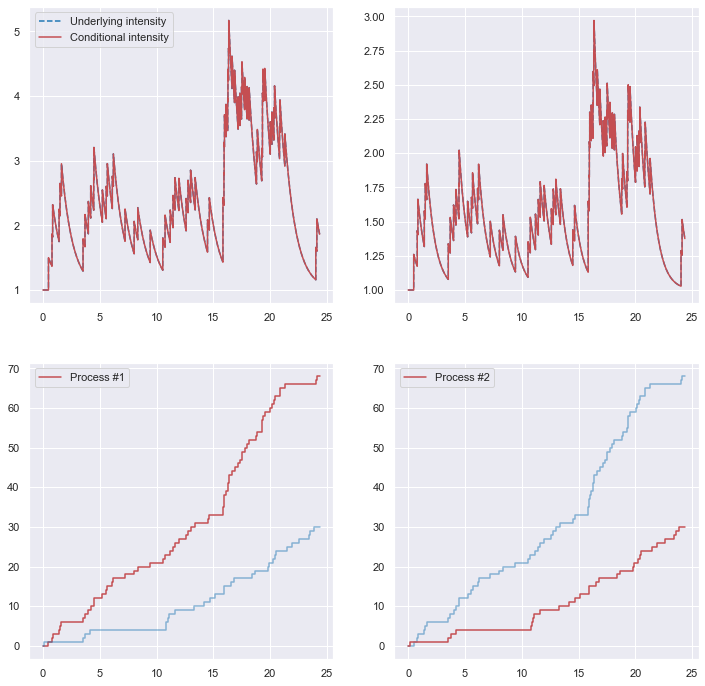

In [7]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
hp.plot_intensity(ax=ax, where=100)

In [8]:
noise = 0.5
pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
pp.simulate()
pp_times = pp.timestamps

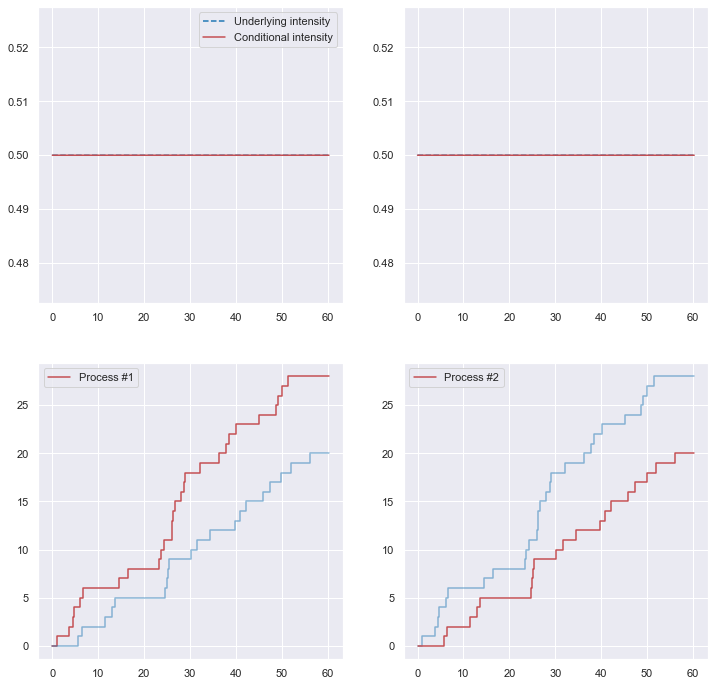

In [9]:
fig, ax = plt.subplots(2,2, figsize=(12,12))
pp.plot_intensity(ax=ax, where=50)

In [10]:
idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
K = int(parasited_times.shape[0]/2)
#K = int(K * np.log(K))
print(K)
start_time = time.time()
periodogram = [multivariate_periodogram(j/max_time, parasited_times) for j in range(1, K+1)]
end_time = time.time()
print(end_time - start_time)


2134
11.60331106185913


In [23]:
dim = 2
bounds = [(1e-16, None) for i in range(dim)]
bounds = bounds + [(1e-16, 1-1e-16) for i in range(dim)] + bounds + [(1e-16, None)]
start_time = time.time()
res = minimize(spectral_multivariate_noised_ll_column,
               [0.1 for _ in range(7)], tol=1e-16,
               method="L-BFGS-B", jac=None,
               args=([i for i in periodogram], K, max_time),
               
               
               bounds=bounds, options={"disp":False})
end_time = time.time()
print("Done with the estimation", end_time - start_time)
print(res.x) 

Done with the estimation 24.05522108078003
[0.49493553 0.36456583 0.60105812 0.18856701 1.50962781 1.39725903
 1.19641487]


In [72]:
mu, alpha, beta, noise, res.x[0:dim], res.x[dim:dim+2].reshape((dim,1)), res.x[-3:-1], res.x[-1]

(array([[1.],
        [1.]]),
 array([[0.5, 0. ],
        [0.2, 0. ]]),
 array([[1. ],
        [1.3]]),
 0.4,
 array([1.20328023, 1.2858807 ]),
 array([[0.47426681],
        [0.20310538]]),
 array([0.95070197, 1.3514292 ]),
 0.01)

In [19]:
res.x[0] + res.x[-1], res2.x[0] + res2.x[-1]

(1.6913503942924693, 1.9365610185444875)

In [24]:
start_time = time.time()
res2 = minimize(spectral_multivariate_noised_ll_column,
               [1.0 for _ in range(dim)] + [0.3 for _ in range(dim)] + [1.0 for _ in range(dim+1)], 
               tol=1e-16,
               method="L-BFGS-B", jac=None,
               args=([i.T for i in periodogram], K, max_time),
               bounds=bounds, options={"disp":False})
end_time = time.time()
print("Done with the estimation", end_time - start_time)
print(res2.x) 

Done with the estimation 43.57289695739746
[2.12681529e-01 1.00000000e-16 6.94802744e-01 1.16360399e-01
 1.91942665e+00 4.14434896e+00 1.72972831e+00]


In [25]:
dim = 2
bounds = [(1e-16, None) for i in range(dim)]
bounds = bounds + [(1e-16, 1-1e-16) for i in range(dim*dim)] + bounds + [(1e-16, None)]
start_time = time.time()
res = minimize(spectral_multivariate_noised_ll,
               [0.1 for _ in range(9)], tol=1e-16,
               method="L-BFGS-B", jac=None,
               args=([i for i in periodogram], K, max_time),
               
               
               bounds=bounds, options={"disp":False})
end_time = time.time()
print("Done with the estimation", end_time - start_time)
print(res.x) 

Done with the estimation 105.95344805717468
[5.06459228e-01 3.44186214e-01 5.98648768e-01 1.00000000e-16
 1.70832628e-01 7.33252302e-02 1.49558837e+00 1.57205208e+00
 1.17540888e+00]


In [26]:
dim = 2
bounds = [(1e-16, None) for i in range(dim)]
bounds = bounds + [(1e-16, 1-1e-16) for i in range(dim*dim)] + bounds + [(1e-16, None)]
start_time = time.time()
res2 = minimize(spectral_multivariate_noised_ll,
               [1.0 for _ in range(dim)] + [0.3 for _ in range(dim*dim)] + [1.0 for _ in range(dim+1)], tol=1e-16,
               method="L-BFGS-B", jac=None,
               args=([i for i in periodogram], K, max_time),
               
               
               bounds=bounds, options={"disp":False})
end_time = time.time()
print("Done with the estimation", end_time - start_time)
print(res2.x) 

Done with the estimation 80.55254316329956
[5.06444758e-01 3.44163316e-01 5.98651882e-01 1.00000000e-16
 1.70832458e-01 7.33300544e-02 1.49560347e+00 1.57208492e+00
 1.17543443e+00]


# Repetitions

In [10]:
max_time = 1000
repetitions = 50
estimations_max = np.zeros((repetitions, 7))
dim = 2
for idx_repet in range(repetitions):
    np.random.seed(idx_repet)
    hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
    hp.simulate()
    hp_times = hp.timestamps
    
    pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
    pp.simulate()
    pp_times = pp.timestamps
    
    idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
    parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
    K = int(parasited_times.shape[0]/2)
    periodogram = [multivariate_periodogram(j/max_time, parasited_times) for j in range(1, K+1)]

    bounds = [(1e-16, None) for i in range(dim)]
    bounds = bounds + [(1e-16, 1-1e-16) for i in range(dim)] + bounds + [(1e-16, None)]
    
    start_time = time.time()
    res = minimize(spectral_multivariate_noised_ll_column,
                   [0.1 for _ in range(7)], tol=1e-16,
                   method="L-BFGS-B", jac=None,
                   args=([i for i in periodogram], K, max_time),


                   bounds=bounds, options={"disp":False})
    end_time = time.time()
    estimations_max[idx_repet, :] = res.x
    print("Estimation #", str(idx_repet + 1))
    if idx_repet == 0:
        print("Time of first estimation: ", end_time - start_time)

Estimation # 1
Time of first estimation:  20.30294895172119
Estimation # 2
Estimation # 3
Estimation # 4
Estimation # 5
Estimation # 6
Estimation # 7
Estimation # 8
Estimation # 9
Estimation # 10
Estimation # 11
Estimation # 12
Estimation # 13
Estimation # 14
Estimation # 15
Estimation # 16
Estimation # 17
Estimation # 18
Estimation # 19
Estimation # 20
Estimation # 21
Estimation # 22
Estimation # 23
Estimation # 24
Estimation # 25
Estimation # 26
Estimation # 27
Estimation # 28
Estimation # 29
Estimation # 30
Estimation # 31
Estimation # 32
Estimation # 33
Estimation # 34
Estimation # 35
Estimation # 36
Estimation # 37
Estimation # 38
Estimation # 39
Estimation # 40
Estimation # 41
Estimation # 42
Estimation # 43
Estimation # 44
Estimation # 45
Estimation # 46
Estimation # 47
Estimation # 48
Estimation # 49
Estimation # 50


In [88]:
mu, alpha, beta, noise, estimations[0:dim], estimations[dim:dim+2].reshape((dim,1)), estimations[-3:-1], estimations[-1]

(array([[1.],
        [1.]]),
 array([[0.5, 0. ],
        [0.2, 0. ]]),
 array([[1. ],
        [1.3]]),
 0.4,
 array([0.96808201, 0.89224265]),
 array([[0.50949963],
        [0.21066552]]),
 array([1.06611536, 1.4645285 ]),
 0.4928495119403796)

In [86]:
mu, alpha, beta, noise, estimations[0:dim], estimations[dim:-dim-1].reshape((dim,dim)), estimations[-dim-1:-1], estimations[-1]

(array([[1.],
        [1.]]),
 array([[0.5, 0. ],
        [0.2, 0. ]]),
 array([[1. ],
        [1.3]]),
 0.4,
 array([1.18595346, 1.18801052]),
 array([[0.47136379, 0.0143373 ],
        [0.19386241, 0.00634105]]),
 array([0.99078896, 1.35262132]),
 0.14617684262250152)

In [11]:
max_time = 1000
repetitions = 50
estimations = np.zeros((repetitions,9))
for idx_repet in range(repetitions):
    np.random.seed(idx_repet)
    hp = multivariate_exponential_hawkes(mu, alpha * beta, beta, max_time=max_time)
    hp.simulate()
    hp_times = hp.timestamps
    
    pp = multivariate_exponential_hawkes(noise * np.ones((2,1)), 0*alpha, beta, max_time=max_time)
    pp.simulate()
    pp_times = pp.timestamps
    
    idx = np.argsort(pp_times[1:-1] + hp_times, axis=0)[:, 0]
    parasited_times = np.array(pp_times[1:-1] + hp_times)[idx]
    K = int(parasited_times.shape[0]/2)
    periodogram = [multivariate_periodogram(j/max_time, parasited_times) for j in range(1, K+1)]

    bounds = [(1e-16, None) for i in range(dim)]
    bounds = bounds + [(1e-16, 1-1e-16) for i in range(dim**2)] + bounds + [(1e-16, None)]
    start_time = time.time()
    res = minimize(spectral_multivariate_noised_ll,
                   [0.1 for _ in range(dim * (2 + dim) + 1)], tol=1e-16,
                   method="L-BFGS-B", jac=None,
                   args=([i for i in periodogram], K, max_time),


                   bounds=bounds, options={"disp":False})
    end_time = time.time()
    estimations[idx_repet, :] = res.x
    print("Estimation #", str(idx_repet + 1))
    if idx_repet == 0:
        print("Time of first estimation: ", end_time - start_time)


Estimation # 1
Time of first estimation:  85.70398902893066
Estimation # 2
Estimation # 3
Estimation # 4
Estimation # 5
Estimation # 6
Estimation # 7
Estimation # 8
Estimation # 9
Estimation # 10
Estimation # 11
Estimation # 12
Estimation # 13
Estimation # 14
Estimation # 15
Estimation # 16
Estimation # 17
Estimation # 18
Estimation # 19
Estimation # 20
Estimation # 21
Estimation # 22
Estimation # 23
Estimation # 24
Estimation # 25
Estimation # 26
Estimation # 27
Estimation # 28
Estimation # 29
Estimation # 30
Estimation # 31
Estimation # 32
Estimation # 33
Estimation # 34
Estimation # 35
Estimation # 36
Estimation # 37
Estimation # 38
Estimation # 39
Estimation # 40
Estimation # 41
Estimation # 42
Estimation # 43
Estimation # 44
Estimation # 45
Estimation # 46
Estimation # 47
Estimation # 48
Estimation # 49
Estimation # 50


In [12]:
np.mean(estimations, axis=0), np.mean(estimations_max, axis=0)

(array([1.2128519 , 1.25143399, 0.46994857, 0.02457328, 0.18874972,
        0.02455752, 0.9681169 , 1.53518469, 0.16559934]),
 array([1.00629463, 0.97792366, 0.51172743, 0.2115396 , 1.04034531,
        1.42926021, 0.51111408]))

In [10]:
theta = np.concatenate((mu.ravel(), alpha.ravel(), beta.ravel(), np.array([noise])))
theta_max = np.concatenate((mu.ravel(), (alpha[alpha > 0.0]).ravel(), beta.ravel(), np.array([noise])))
theta, theta_max

(array([1.  , 1.  , 0.5 , 0.35, 0.4 , 0.5 , 1.  , 1.3 , 0.5 ]),
 array([1.  , 1.  , 0.5 , 0.35, 0.4 , 0.5 , 1.  , 1.3 , 0.5 ]))

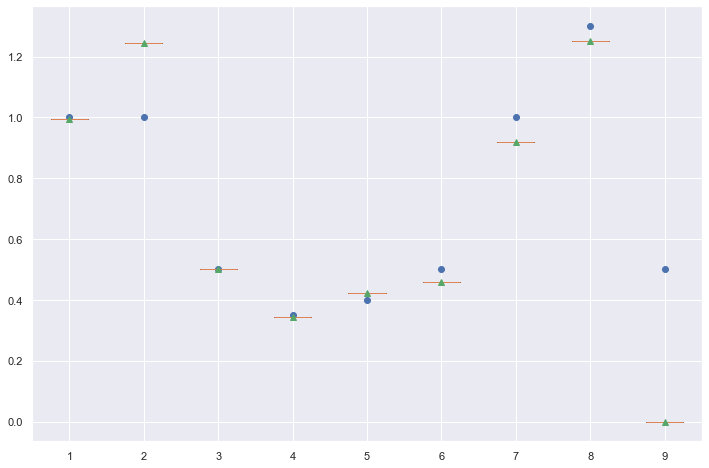

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = ax.boxplot(estimations_init[[0,3,4], :], showmeans=True)
_ = ax.scatter(range(1, 10), theta)



In [43]:
estimations_init[:, :]

array([[9.96204424e-01, 1.24452205e+00, 5.00462746e-01, 3.44863288e-01,
        4.23537971e-01, 4.58148667e-01, 9.17795334e-01, 1.25190900e+00,
        1.00000000e-16],
       [1.65334596e+00, 1.90537966e+00, 9.25507600e-01, 9.38433581e-01,
        9.33232559e-01, 9.31848933e-01, 8.58101959e-01, 9.42263775e-01,
        1.92675095e+00],
       [1.16179760e+00, 9.81454534e-01, 9.75856885e-01, 8.87377126e-01,
        1.00000000e+00, 9.42290953e-01, 8.61541988e-01, 1.07247719e+00,
        1.05682008e+00],
       [9.96214928e-01, 1.24444515e+00, 5.00466131e-01, 3.44860184e-01,
        4.23536007e-01, 4.58158224e-01, 9.17777784e-01, 1.25187859e+00,
        1.00000000e-16],
       [9.96198483e-01, 1.24443381e+00, 5.00464511e-01, 3.44862264e-01,
        4.23543578e-01, 4.58154119e-01, 9.17795532e-01, 1.25187428e+00,
        1.00000000e-16]])

In [39]:
norm(estimations_init[:, 2:6], ord=2, axis=1)

array([0.87102139, 1.86453408, 1.9046383 , 0.87102618, 0.87102759])

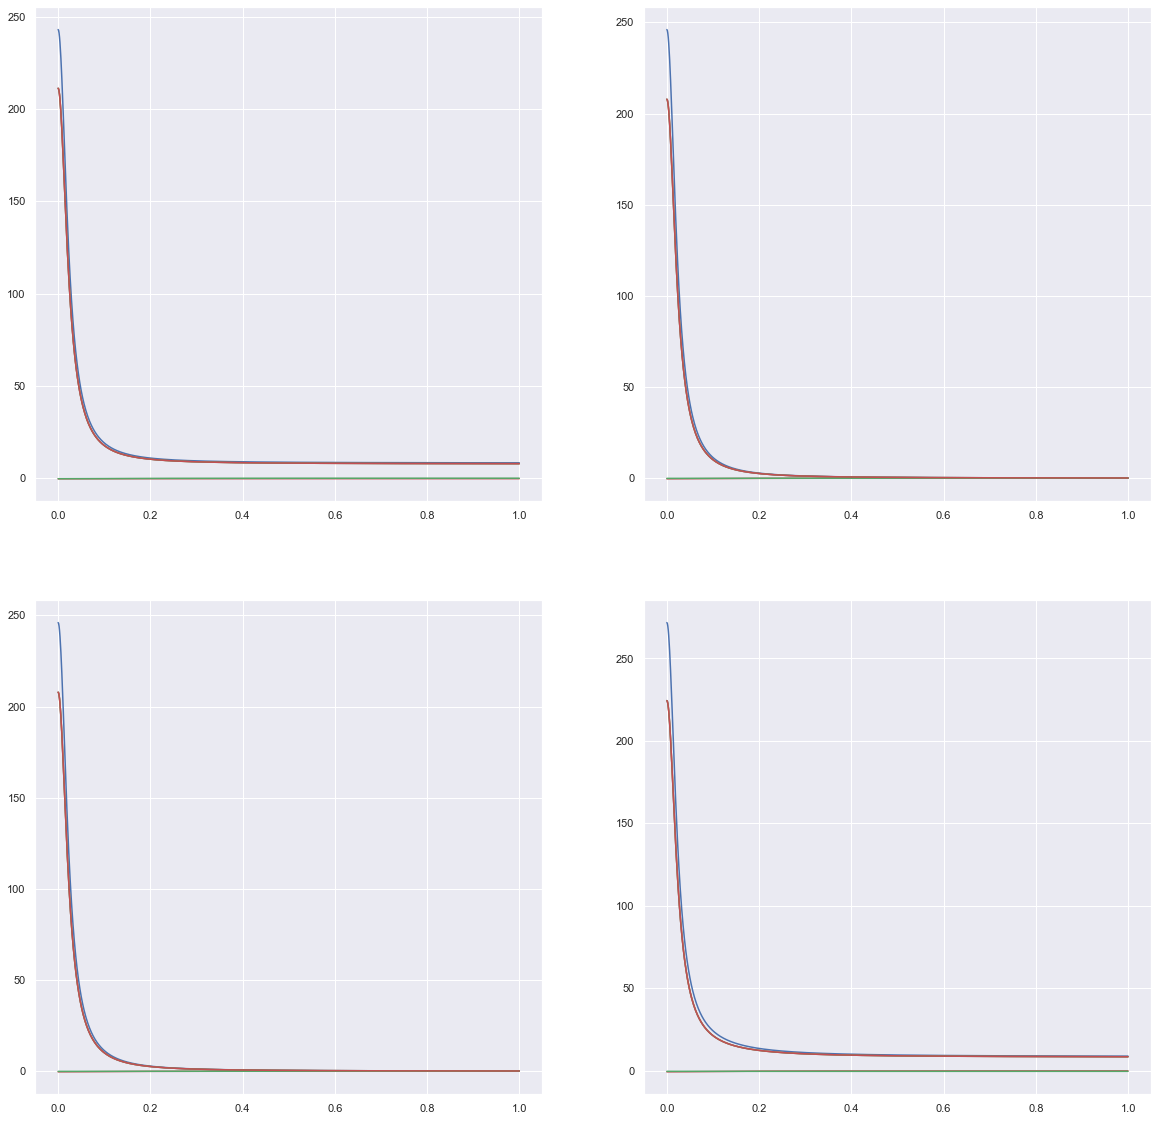

In [35]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))
x = np.linspace(0, 1, 1000)
density_mat = np.array([multivariate_spectral_noised_density(x_0, (mu, alpha, beta, noise)).real for x_0 in x])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(x, density_mat[:, i, j])
for k in range(5):
    mu_est, alpha_est = estimations_init[k, 0:2], estimations_init[k, 2:6].reshape((2,2))
    beta_est, noise_est =  estimations_init[k, 6:8], estimations_init[k, 8:9]
    density_mat = np.array([multivariate_spectral_noised_density(x_0, (mu_est, alpha_est, beta_est, noise_est)).real for x_0 in x])
    for i in range(2):
        for j in range(2):
            if k in [0,1,4]:
                ax[i,j].plot(x, density_mat[:, i, j], c="r")
            else:
                ax[i,j].plot(x, density_mat[:, i, j], c="g")


In [22]:
import pickle
with open('estimationsFullConjectureRepet220324.pkl', 'rb') as file:
    _, estimations = pickle.load(file)

In [23]:
estimations.shape

(100, 9)

In [24]:
estimations.mean(axis=0)

array([0.88264451, 0.92102433, 0.62609198, 0.5196684 , 0.56184268,
       0.64935741, 1.13515376, 1.46252874, 1.79312717])

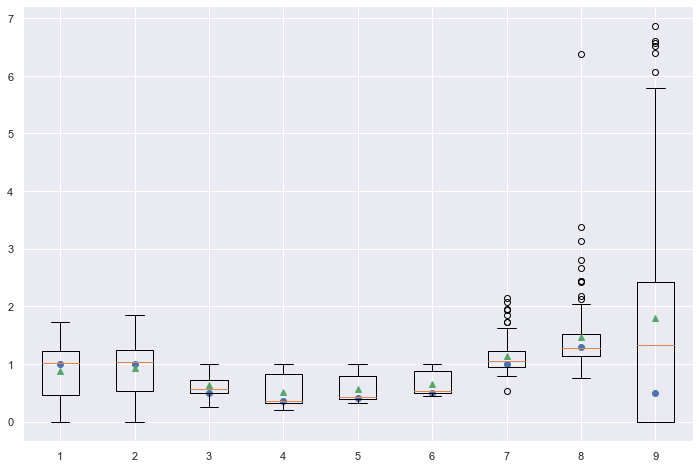

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = ax.boxplot(estimations, showmeans=True)
_ = ax.scatter(range(1, 10), theta)



In [80]:
estimations.shape
aux.shape, aux.sum()

((100,), 64)

In [82]:
aux = norm(estimations[:, 0:1], ord=2, axis=1) > 2e-16
aux.sum()

97

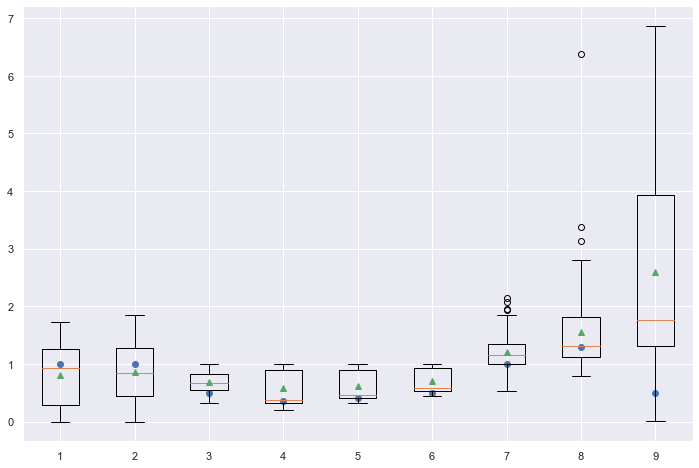

In [12]:
aux = norm(estimations[:, -1:], ord=2, axis=1) > 2e-16

fig, ax = plt.subplots(1, 1, figsize=(12,8))
_ = ax.boxplot(estimations[aux, :], showmeans=True)
_ = ax.scatter(range(1, 10), theta)



In [90]:
np.sort(estimations[:, 0:1].squeeze())

array([1.00000000e-16, 1.00000000e-16, 1.00000000e-16, 5.67622347e-03,
       3.64313425e-02, 5.36371889e-02, 6.42633555e-02, 7.24902807e-02,
       7.60627959e-02, 7.69739066e-02, 9.61620560e-02, 1.01066826e-01,
       1.39013267e-01, 1.45760072e-01, 1.70697373e-01, 2.09614882e-01,
       2.37868451e-01, 2.67585327e-01, 2.82448956e-01, 2.95559205e-01,
       3.68787523e-01, 3.74042611e-01, 3.96898361e-01, 4.25982519e-01,
       4.40560524e-01, 4.60519389e-01, 5.19194231e-01, 5.70777752e-01,
       5.86120047e-01, 6.14610660e-01, 6.70063659e-01, 6.72004392e-01,
       7.00114229e-01, 7.89120234e-01, 7.98179592e-01, 8.23781133e-01,
       8.47811132e-01, 9.16625096e-01, 9.35417827e-01, 9.56519608e-01,
       9.57196588e-01, 9.64533704e-01, 9.77136511e-01, 9.77746378e-01,
       9.80386474e-01, 9.86574488e-01, 9.88835344e-01, 9.94162478e-01,
       9.96171209e-01, 1.00729115e+00, 1.01104960e+00, 1.03622005e+00,
       1.03954092e+00, 1.04337497e+00, 1.04487882e+00, 1.04860486e+00,
      

(array([15.,  5.,  7.,  5.,  5., 16., 21., 13., 10.,  3.]),
 array([1.00000000e-16, 1.73512452e-01, 3.47024904e-01, 5.20537356e-01,
        6.94049808e-01, 8.67562260e-01, 1.04107471e+00, 1.21458716e+00,
        1.38809962e+00, 1.56161207e+00, 1.73512452e+00]),
 <BarContainer object of 10 artists>)

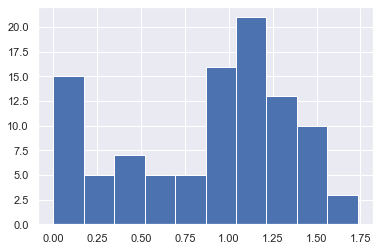

In [93]:
fig, ax = plt.subplots()
ax.hist(np.sort(estimations[:, 0:1].squeeze()))

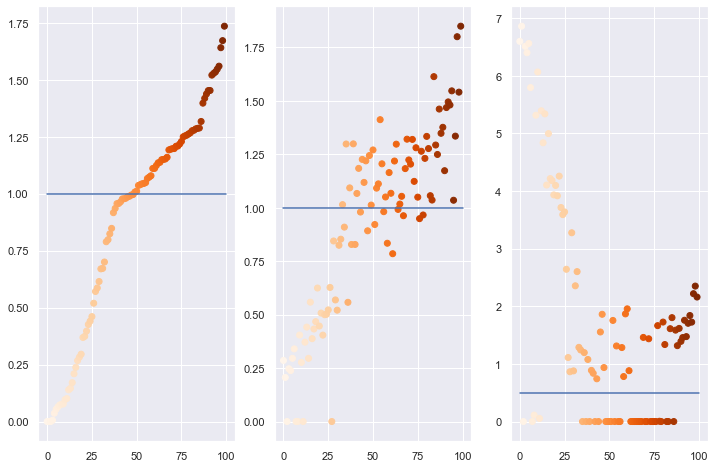

In [13]:
# See compensation in beta 
fig, ax = plt.subplots(1, 3, figsize=(12,8))
sort_id = np.argsort(estimations[:, 0].squeeze())
for idx_parameter in [0, 1, -1]:
    ax[idx_parameter].scatter(np.arange(100), estimations[sort_id, idx_parameter], 
                  c=np.arange(100), cmap="Oranges")
    ax[idx_parameter].plot([0,100], [theta[idx_parameter]]*2)
    #print(np.corrcoef(estimations))

#plt.savefig("compensation_beta.pdf", format="pdf")

In [20]:
estimations[:, -1] > 1e-16

array([False, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False,  True,  True, False,
        True,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True,  True,  True,  True, False,  True,  True,
        True, False,  True,  True,  True, False,  True, False,  True,
        True,  True,  True, False,  True,  True,  True, False,  True,
       False,  True,  True,  True, False, False, False, False,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False,  True, False,  True,  True,
        True,  True,  True, False,  True,  True, False,  True, False,
       False])

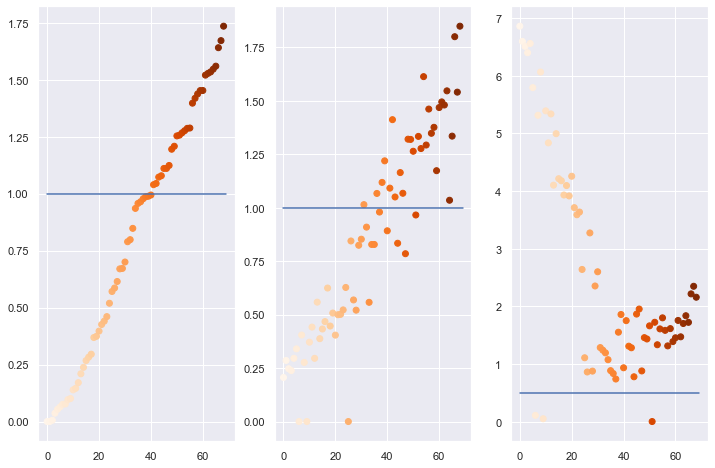

In [21]:
# See compensation in beta 
fig, ax = plt.subplots(1, 3, figsize=(12,8))
aux = estimations[estimations[:, -1] > 1e-16, :] 
sort_id = np.argsort(aux[:, 0].squeeze())
for idx_parameter in [0, 1, -1]:
    ax[idx_parameter].scatter(np.arange(aux.shape[0]), aux[sort_id, idx_parameter], 
                  c=np.arange(aux.shape[0]), cmap="Oranges")
    ax[idx_parameter].plot([0,aux.shape[0]], [theta[idx_parameter]]*2)
    #print(np.corrcoef(estimations))

#plt.savefig("compensation_beta.pdf", format="pdf")

In [56]:
estimations[aux, :].mean(axis=0)

array([0.79101185, 0.84850508, 0.53362126, 0.32632531, 0.40369031,
       0.50775411, 1.176702  , 1.58647357, 1.8803769 ])

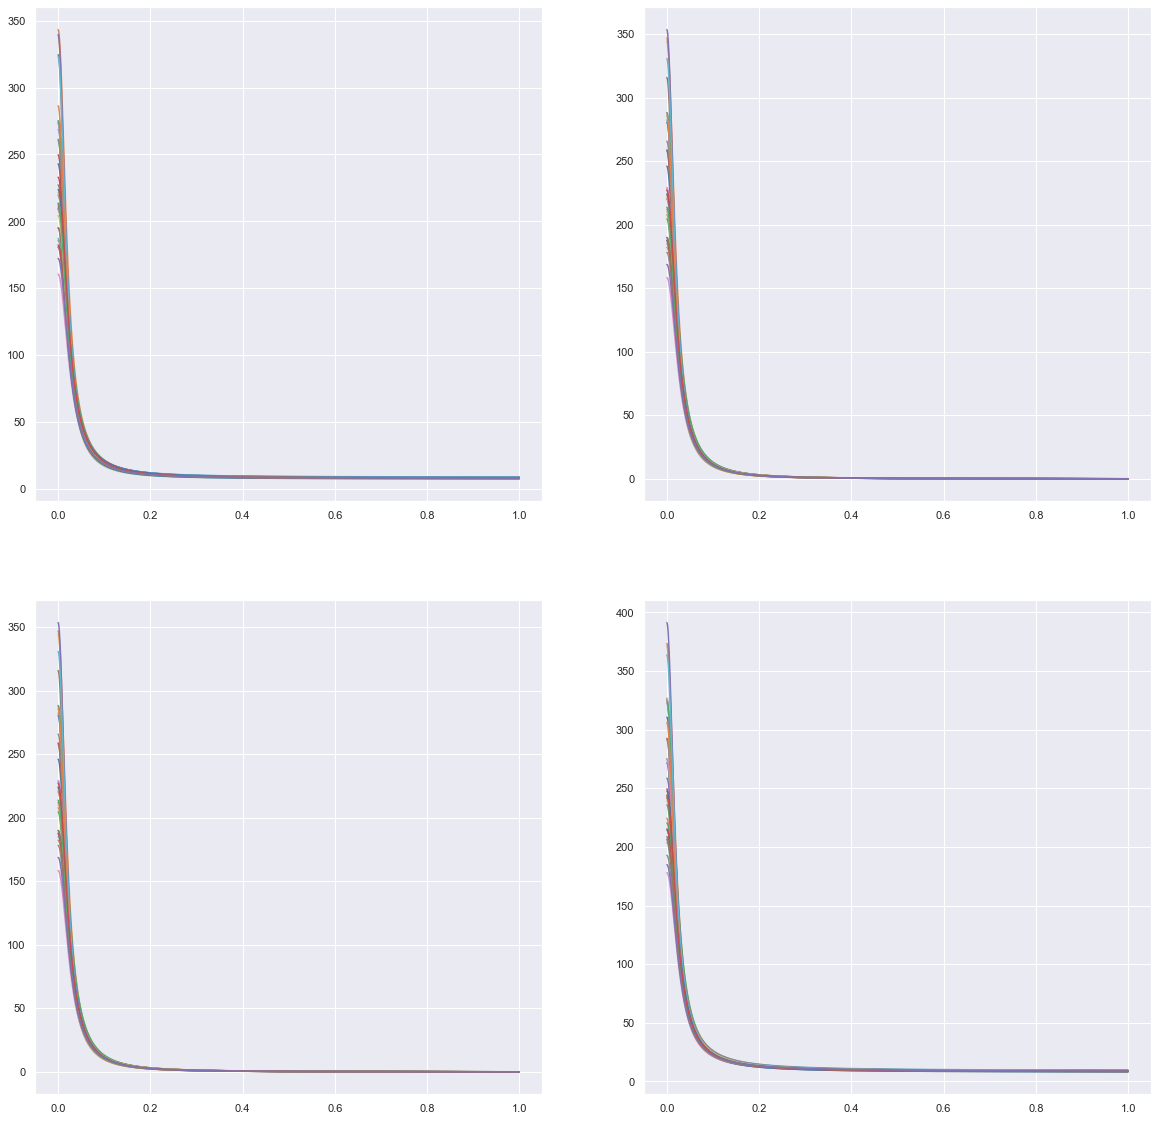

In [53]:
fig, ax = plt.subplots(2, 2, figsize=(20,20))
x = np.linspace(0, 1, 1000)
density_mat = np.array([multivariate_spectral_noised_density(x_0, (mu, alpha, beta, noise)).real for x_0 in x])
for i in range(2):
    for j in range(2):
        ax[i,j].plot(x, density_mat[:, i, j])
for k in range(50):
    mu_est, alpha_est = estimations[k, 0:2], estimations[k, 2:6].reshape((2,2))
    beta_est, noise_est =  estimations[k, 6:8], estimations[k, 8:9]
    density_mat = np.array([multivariate_spectral_noised_density(x_0, (mu_est, alpha_est, beta_est, noise_est)).real for x_0 in x])
    for i in range(2):
        for j in range(2):
            if aux[k]:
                ax[i,j].plot(x, density_mat[:, i, j])
